## Modelo Baseline

### 1.0 Importando as Libs

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### 2.0 Carregando o dataset

In [2]:
prices_df = pd.read_csv("../data/processed/model_df.csv", sep=',', encoding='latin1')

In [3]:
@interact
def show_prices_df(ram=prices_df['Ram'].unique()):
    return prices_df[prices_df.Ram == ram]

interactive(children=(Dropdown(description='ram', options=(8, 16, 4, 2, 12, 6, 32, 24, 64), value=8), Output()…

In [4]:
prices_df

,OpSys_No OS,company_MSI,CPU_BRAND_AMD,CPU_BRAND_Intel,GPU_BRAND_Intel,GPU_BRAND_AMD,company_Acer,Weight,Memory_Type_Flash,typeName_Workstation,...,GPU_BRAND_Nvidia,typeName_Gaming,Memory_Type_HDD,CPU_FREQUENCY,Memory_Type_SSD,typeName_Notebook,ScreenHeight,ScreenWidth,Ram,Price_euros
0,0,0,0,1,1,0,0,1.37,0,0,...,0,0,0,2.3,1,0,1600,2560,8,1339.69
1,0,0,0,1,1,0,0,1.34,1,0,...,0,0,0,1.8,0,0,900,1440,8,898.94
2,1,0,0,1,1,0,0,1.86,0,0,...,0,0,0,2.5,1,1,1080,1920,8,575.00
3,0,0,0,1,0,1,0,1.83,0,0,...,0,0,0,2.7,1,0,1800,2880,16,2537.45
4,0,0,0,1,1,0,0,1.37,0,0,...,0,0,0,3.1,1,0,1600,2560,8,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,0,0,0,1,1,0,0,1.80,0,0,...,0,0,0,2.5,1,0,1080,1920,4,638.00
1299,0,0,0,1,1,0,0,1.30,0,0,...,0,0,0,2.5,1,0,1800,3200,16,1499.00
1300,0,0,0,1,1,0,0,1.50,1,0,...,0,0,0,1.6,0,1,768,1366,2,229.00
1301,0,0,0,1,0,1,0,2.19,0,0,...,0,0,1,2.5,0,1,768,1366,6,764.00


#### 3.1 Train Test Split

In [5]:
X, y = prices_df.drop("Price_euros", axis=1), prices_df["Price_euros"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [7]:
# feature_scaler = StandardScaler()
# X_train = feature_scaler.fit_transform(X_train)
# X_test = feature_scaler.transform(X_test)
# X_val = feature_scaler.transform(X_val)

#### 3.2 Train the model

In [8]:
model = XGBRegressor(eval_metric=["mae", "logloss"])
model = model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=0
)

In [9]:
# predict on the validation set
predictions = model.predict(X_test)

# Get evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Score the model
print("Score: {:.2f}".format(model.score(X_test, y_test)))

# test_df = pd.DataFrame(X_test)
# test_df['Actuals'] = y_test
# test_df['Predictions'] = predictions

Score: 0.89


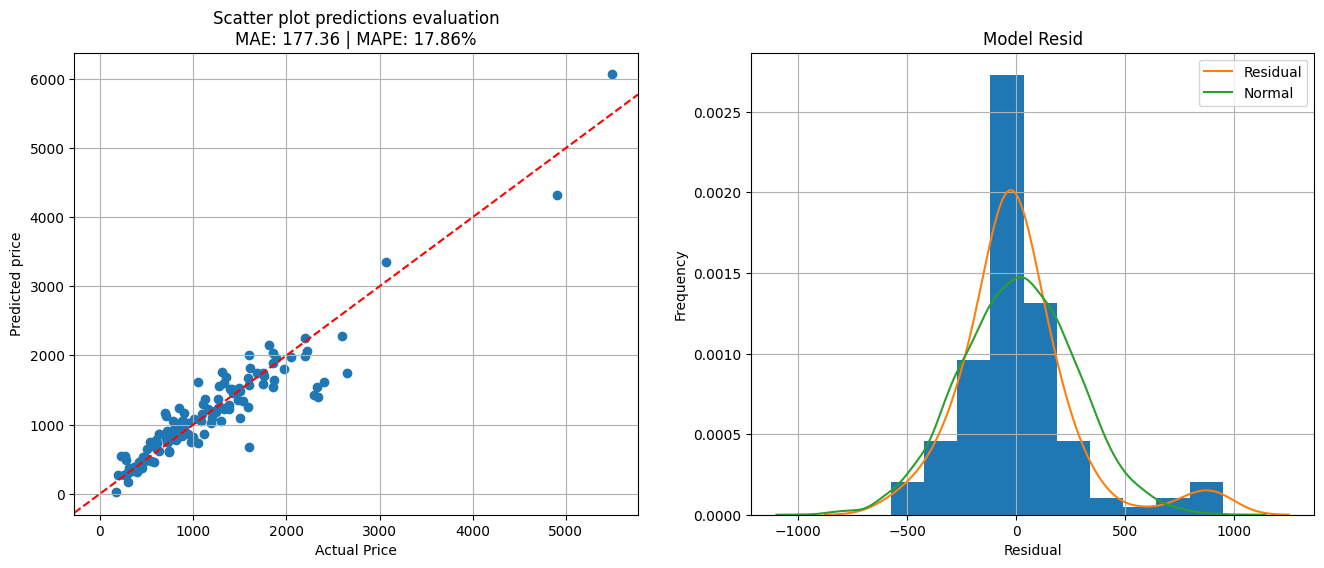

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot diagonal line
axs[0].axline((1,1), slope=1, color='r', ls='--')
# Scatter predictions vs true
axs[0].scatter(x=y_test, y=predictions)
axs[0].set_title(f"Scatter plot predictions evaluation\nMAE: {round(mae, 2)} | MAPE: {round(mape, 4)*100}%")
axs[0].set_xlabel("Actual Price")
axs[0].set_ylabel("Predicted price")
axs[0].grid()

# Plot the Residuals
residuals = y_test - predictions
axs[1].hist(residuals, density=True)
axs[1].set_title("Model Resid")
axs[1].set_xlabel("Residual")
axs[1].set_ylabel("Frequency")
sns.kdeplot(residuals, label='Residual')
s = np.random.normal(0, np.std(residuals), 10000)
sns.kdeplot(s, label='Normal')

axs[1].grid()
plt.legend()
plt.show()

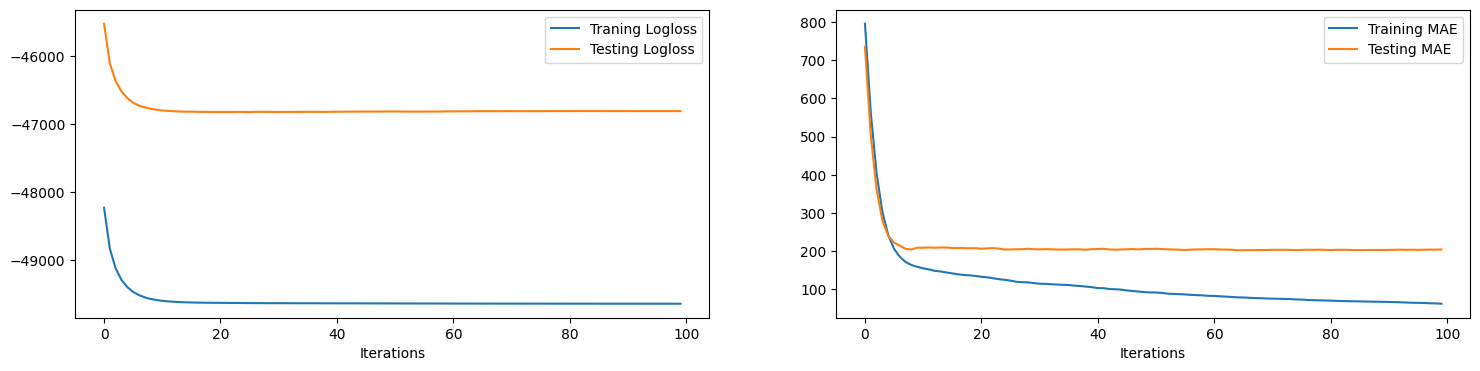

In [11]:
# plot learning curves
learning_results = model.evals_result()

fig, axs = plt.subplots(1, 2, figsize=(18, 4))
axs[0].plot(learning_results['validation_0']['logloss'], label='Traning Logloss')
axs[0].plot(learning_results['validation_1']['logloss'], label='Testing Logloss')

axs[1].plot(learning_results['validation_0']['mae'], label='Training MAE')
axs[1].plot(learning_results['validation_1']['mae'], label='Testing MAE')

axs[0].set_xlabel("Iterations")
axs[1].set_xlabel("Iterations")
# show the legend
axs[0].legend()
axs[1].legend()
# show the plot
plt.show()

### 3.3 Perform Hyperparameter Optimization

In [13]:
param_grid = {
        'min_child_weight': [7, 10, 12, 15, None],
        'gamma': [0.01, 0.05, 0.1, 0.25, 0.5, None],
        'subsample': [0.8, 1.0, None],
        'colsample_bytree': [0.8, 1.0, None],
        'max_depth': [5, 7, 10, 13, None],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, None],
        'n_estimators': [40, 100]
}

In [14]:
y_train_log = np.log(y_train)

In [15]:
gridsearcher = GridSearchCV(
    estimator=XGBRegressor(),#(booster='dart'),
    param_grid = param_grid,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
    n_jobs=8
)

# gridsearcher = gridsearcher.fit(X_train, y_train_log)
# print('\nBest hyperparameters:')
# print(gridsearcher.best_params_)
# results = pd.DataFrame(gridsearcher.cv_results_)

### Transformando para escala logarítimica

In [16]:
plt.style.use('default')

In [17]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
y_val_log = np.log(y_val)

In [18]:
model = XGBRegressor(**{'colsample_bytree': 1.0, 
                        'gamma': 0.5, 
                        'learning_rate': 0.05, 
                        'max_depth': 16, 
                        'min_child_weight': 10, 
                        'n_estimators': 70, 
                        'subsample': 1.0},
                        eval_metric=["mae", "logloss"],
                        )
model = model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
              verbose=0
)

In [19]:
from sklearn.metrics import r2_score
# predict on the validation set
predictions = model.predict(X_test)

# Convert back
#predictions = np.exp(predictions)

mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = round(r2_score(y_test, predictions), 2)

print("MAE: ",mae)
print("MAPE: ",mape)
print("R²: ",r2)
model.score(X_test, y_test)

MAE:  194.2156832369291
MAPE:  0.1810849077562289
R²:  0.83


0.8316985778065683

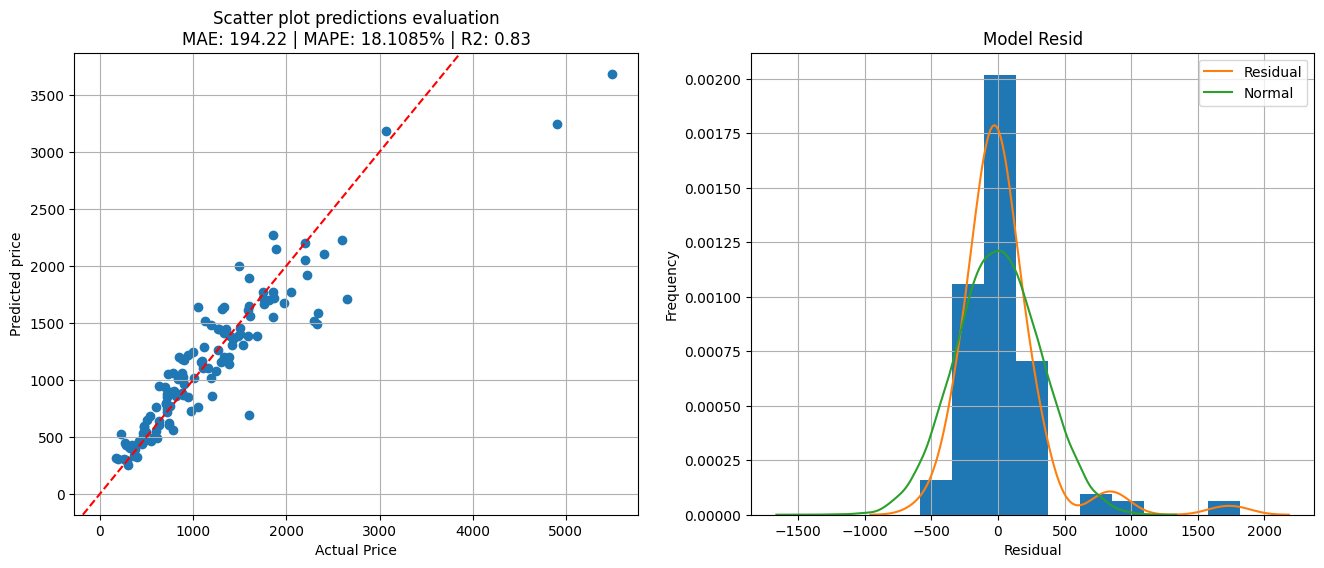

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot diagonal line
axs[0].axline((1,1), slope=1, color='r', ls='--')
# Scatter predictions vs true
axs[0].scatter(x=y_test, y=predictions)
axs[0].set_title(f"Scatter plot predictions evaluation\nMAE: {round(mae, 2)} | MAPE: {round(mape*100, 4)}% | R2: {r2}")
axs[0].set_xlabel("Actual Price")
axs[0].set_ylabel("Predicted price")
axs[0].grid()

# Plot the Residuals
residuals = y_test - predictions
axs[1].hist(residuals, density=True)
axs[1].set_title("Model Resid")
axs[1].set_xlabel("Residual")
axs[1].set_ylabel("Frequency")
sns.kdeplot(residuals, label='Residual')
s = np.random.normal(0, np.std(residuals), 20000)
sns.kdeplot(s, label='Normal')

axs[1].grid()
plt.legend()
plt.show()

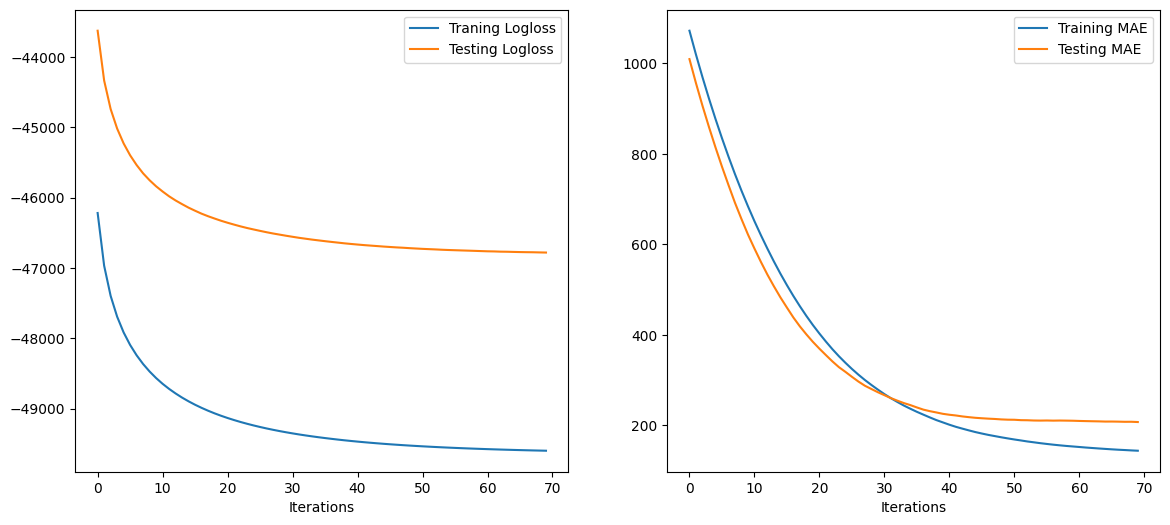

In [21]:
# plot learning curves
learning_results = model.evals_result()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(learning_results['validation_0']['logloss'], label='Traning Logloss')
axs[0].plot(learning_results['validation_1']['logloss'], label='Testing Logloss')

axs[1].plot(learning_results['validation_0']['mae'], label='Training MAE')
axs[1].plot(learning_results['validation_1']['mae'], label='Testing MAE')

axs[0].set_xlabel("Iterations")
axs[1].set_xlabel("Iterations")
# show the legend
axs[0].legend()
axs[1].legend()
# show the plot
plt.show()

<Axes: >

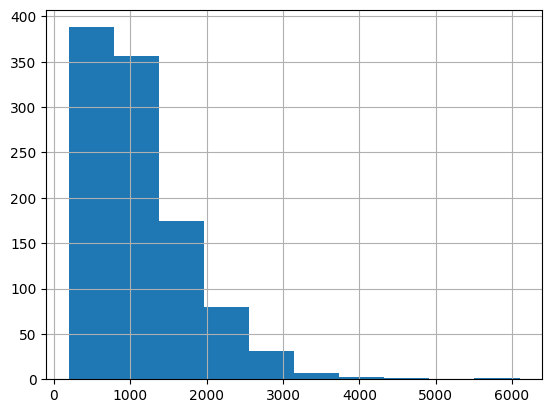

In [22]:
y_train.hist()

<Axes: >

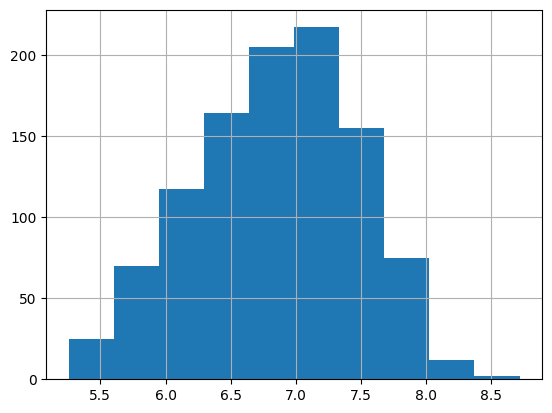

In [23]:
np.log(y_train).hist()

In [24]:
y_train

999     2089.00
1073    1090.00
282      829.00
1123     523.63
289      659.01
         ...   
268     1018.00
683      699.00
1019    2229.00
522     1279.73
466      469.00
Name: Price_euros, Length: 1042, dtype: float64